In [1]:
%matplotlib inline
import numpy as np
import scipy
from scipy.io import loadmat

In [2]:
USE_CUDNN = True

In [3]:
data = loadmat('./dataset.mat')

In [4]:
print list(data)

['__header__', '__globals__', 'test_data', 'test_label', '__version__', 'train_label', 'train_data']


From 林敬翔 之銘言：
跟助教要的 dataset

第一維是數量 第二維是時間序 第三維是資料量

Label 1~3是第一個動作 1是動作評估為好 2是動作評估為普通 3是動作評估為差 以此類推 4~6是第二個動作 ....

1-10左手腕 11-20右手腕 21-30左手臂 31-40右手臂

220代表frame數

我是取一秒25frame

動作數量是以動作為單位沒錯 1*220*40表是某一個動作的完整資料

以下資料維度

data: (?, 220, 40) = (幾筆資料, 時間步, 資料維度)

label: (?, 1) = (幾筆資料, 動作label)

動作 label: 1~3是第一個動作 1是動作評估為好 2是動作評估為普通 3是動作評估為差 以此類推 4~6是第二個動作 ....

In [5]:
for key, value in data.iteritems():
    print 'key: %s'%key
    if hasattr(value , 'shape'):
        print value.shape
    else:
        print 'not an array'

key: __header__
not an array
key: __globals__
not an array
key: test_data
(130, 220, 40)
key: test_label
(130, 1)
key: __version__
not an array
key: train_label
(600, 1)
key: train_data
(600, 220, 40)


序列資料 + 預測 -> RNN? / HMM?

In [6]:
# 使用 Keras CuDNNLSTM
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
import keras
from keras.models import Sequential, load_model, Model
from keras.layers import Dense, Activation, Dropout, Input, Flatten, Conv1D, MaxPool1D
from keras.layers import LSTM, CuDNNLSTM, RepeatVector, TimeDistributed, Bidirectional
from keras import regularizers
from keras.optimizers import RMSprop
from keras.utils.io_utils import HDF5Matrix
from keras.utils import to_categorical # one-hot encoding
from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger

from keras import backend as K

Using TensorFlow backend.


In [7]:
def build_model(input_shape, actions=40, cell_size=128, lstm_layer_n = 3, conv_filters=64, 
                conv_kernel=7, pooling_step=2, learning_rate=0.01, dropout_r=0.14, 
                optimizer=keras.optimizers.RMSprop, clipnorm=1., 
                tLSTM=LSTM, use_temporal_subsampling=False):
    if lstm_layer_n<1: raise ValueError('lstm_layer_n must >= 1')
    optimizer = optimizer(lr=learning_rate, clipnorm=clipnorm)
    model = Sequential()
    model.add(Dropout(0, input_shape=input_shape))
    if use_temporal_subsampling:
        model.add(Conv1D(filters=conv_filters, kernel_size=conv_kernel, padding='same', activation='relu'))
        model.add(MaxPool1D(pool_size=pooling_step))
        model.add(Dropout(dropout_r))
    for _ in xrange(1, lstm_layer_n):
        model.add(#Bidirectional(
                                tLSTM(cell_size, return_sequences=True,
                                      unit_forget_bias=True, recurrent_regularizer=regularizers.l2(0.001))#,
                                #merge_mode='sum'
                               )#)
        model.add(Dropout(dropout_r))
    model.add(#Bidirectional(
                            tLSTM(cell_size, return_sequences=False, unit_forget_bias=True, 
                                  recurrent_regularizer=regularizers.l2(0.001))#,
                            #merge_mode='sum'
                           )#)
    model.add(Dropout(dropout_r))
    model.add(Dense(actions, activation='softmax'))
    model.compile(
            loss = 'categorical_crossentropy',
            optimizer=optimizer, metrics=['accuracy']
    )
    return model

In [8]:
from sklearn.preprocessing import OneHotEncoder as OHE
from sklearn.decomposition import PCA

X_train, X_test, y_train, y_test = data['train_data'], data['test_data'], data['train_label'], data['test_label']
label_enc = OHE(sparse=False) # One-hot encoder, which has attribute [transform, inverse_transform]
y_test = label_enc.fit_transform(y_test)
y_train = label_enc.transform(y_train)

pcas = []
n_comp = 12
X_train_new = np.zeros((X_train.shape[0], X_train.shape[1], n_comp))
X_test_new = np.zeros((X_test.shape[0], X_test.shape[1], n_comp))
for i in xrange(X_train.shape[-2]):
    pca = PCA(n_components=n_comp).fit(X_train[:,i,:])
    pcas.append( (pca, np.sum(pca.explained_variance_ratio_)) )
    X_train_new[:,i,:] = pcas[-1][0].transform(X_train[:,i,:])
    X_test_new[:,i,:] = pcas[-1][0].transform(X_test[:,i,:])

X_train = X_train_new
X_test = X_test_new
del X_train_new
del X_test_new

for i, pca in enumerate(pcas):
    print 'info for %d pca: %.2f'%(i,pca[1])

print X_train.shape
print X_test.shape
print y_train.shape
print y_test.shape

info for 0 pca: 1.00
info for 1 pca: 1.00
info for 2 pca: 1.00
info for 3 pca: 1.00
info for 4 pca: 1.00
info for 5 pca: 1.00
info for 6 pca: 1.00
info for 7 pca: 1.00
info for 8 pca: 1.00
info for 9 pca: 1.00
info for 10 pca: 1.00
info for 11 pca: 1.00
info for 12 pca: 1.00
info for 13 pca: 1.00
info for 14 pca: 1.00
info for 15 pca: 1.00
info for 16 pca: 1.00
info for 17 pca: 1.00
info for 18 pca: 1.00
info for 19 pca: 1.00
info for 20 pca: 1.00
info for 21 pca: 1.00
info for 22 pca: 1.00
info for 23 pca: 1.00
info for 24 pca: 1.00
info for 25 pca: 1.00
info for 26 pca: 1.00
info for 27 pca: 1.00
info for 28 pca: 1.00
info for 29 pca: 1.00
info for 30 pca: 1.00
info for 31 pca: 1.00
info for 32 pca: 1.00
info for 33 pca: 1.00
info for 34 pca: 1.00
info for 35 pca: 1.00
info for 36 pca: 1.00
info for 37 pca: 1.00
info for 38 pca: 1.00
info for 39 pca: 1.00
info for 40 pca: 1.00
info for 41 pca: 1.00
info for 42 pca: 1.00
info for 43 pca: 1.00
info for 44 pca: 1.00
info for 45 pca: 1.0

In [9]:
model = build_model(input_shape=X_test.shape[1:] ,actions=y_test.shape[-1], cell_size=100, lstm_layer_n=1,
                    learning_rate=0.0001, dropout_r=0.5,
                    tLSTM=CuDNNLSTM if USE_CUDNN else LSTM, use_temporal_subsampling=False
                   )
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_1 (Dropout)          (None, 220, 12)           0         
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, 100)               45600     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 12)                1212      
Total params: 46,812
Trainable params: 46,812
Non-trainable params: 0
_________________________________________________________________


In [10]:
early_stop = EarlyStopping(patience=20, mode='auto', monitor='val_loss')
checkPoint = ModelCheckpoint(filepath="top_weight.h5", verbose=1, save_best_only=True, save_weights_only=True, period=5)
Logs = CSVLogger('logs.csv', separator=',', append=True)
history = model.fit(X_train, y_train, epochs=3000, batch_size=64, shuffle=True, validation_split=0.15, callbacks=[checkPoint, Logs, early_stop])

Train on 510 samples, validate on 90 samples
Epoch 1/3000
510/510 [==============================] - 2s 4ms/step - loss: 2.8409 - acc: 0.1020 - val_loss: 2.6361 - val_acc: 0.1556
Epoch 2/3000
510/510 [==============================] - 0s 697us/step - loss: 2.7316 - acc: 0.1255 - val_loss: 2.5889 - val_acc: 0.1667
Epoch 3/3000
510/510 [==============================] - 0s 596us/step - loss: 2.6795 - acc: 0.1294 - val_loss: 2.5491 - val_acc: 0.1778
Epoch 4/3000
510/510 [==============================] - 0s 643us/step - loss: 2.6959 - acc: 0.1235 - val_loss: 2.5153 - val_acc: 0.1778
Epoch 5/3000
510/510 [==============================] - 0s 655us/step - loss: 2.6000 - acc: 0.1451 - val_loss: 2.4827 - val_acc: 0.2111
Epoch 6/3000
510/510 [==============================] - 0s 604us/step - loss: 2.5739 - acc: 0.1373 - val_loss: 2.4524 - val_acc: 0.2222
Epoch 7/3000
510/510 [==============================] - 0s 631us/step - loss: 2.5659 - acc: 0.1627 - val_loss: 2.4217 - val_acc: 0.2222
Epoch

Epoch 50/3000
510/510 [==============================] - 0s 604us/step - loss: 1.6511 - acc: 0.4627 - val_loss: 1.7032 - val_acc: 0.5000
Epoch 51/3000
510/510 [==============================] - 0s 578us/step - loss: 1.6709 - acc: 0.4471 - val_loss: 1.6925 - val_acc: 0.5000
Epoch 52/3000
510/510 [==============================] - 0s 578us/step - loss: 1.6690 - acc: 0.4765 - val_loss: 1.6835 - val_acc: 0.5111
Epoch 53/3000
510/510 [==============================] - 0s 590us/step - loss: 1.6394 - acc: 0.4824 - val_loss: 1.6712 - val_acc: 0.5000
Epoch 54/3000
510/510 [==============================] - 0s 603us/step - loss: 1.6161 - acc: 0.4725 - val_loss: 1.6618 - val_acc: 0.5000
Epoch 55/3000
510/510 [==============================] - 0s 593us/step - loss: 1.6121 - acc: 0.4824 - val_loss: 1.6514 - val_acc: 0.4889
Epoch 56/3000
510/510 [==============================] - 0s 583us/step - loss: 1.6289 - acc: 0.4510 - val_loss: 1.6424 - val_acc: 0.4889
Epoch 57/3000
510/510 [==================

Epoch 98/3000
510/510 [==============================] - 0s 648us/step - loss: 1.2661 - acc: 0.5608 - val_loss: 1.3159 - val_acc: 0.6111
Epoch 99/3000
510/510 [==============================] - 0s 635us/step - loss: 1.2663 - acc: 0.5765 - val_loss: 1.3110 - val_acc: 0.6000
Epoch 100/3000
510/510 [==============================] - 0s 612us/step - loss: 1.2490 - acc: 0.6098 - val_loss: 1.3093 - val_acc: 0.6111
Epoch 101/3000
510/510 [==============================] - 0s 617us/step - loss: 1.2286 - acc: 0.5784 - val_loss: 1.3055 - val_acc: 0.6111
Epoch 102/3000
510/510 [==============================] - 0s 619us/step - loss: 1.2489 - acc: 0.5706 - val_loss: 1.2983 - val_acc: 0.6222
Epoch 103/3000
510/510 [==============================] - 0s 601us/step - loss: 1.2528 - acc: 0.5804 - val_loss: 1.2889 - val_acc: 0.6000
Epoch 104/3000
510/510 [==============================] - 0s 751us/step - loss: 1.2290 - acc: 0.5902 - val_loss: 1.2887 - val_acc: 0.6222
Epoch 105/3000
510/510 [============

Epoch 146/3000
510/510 [==============================] - 0s 545us/step - loss: 1.0506 - acc: 0.6510 - val_loss: 1.1238 - val_acc: 0.6333
Epoch 147/3000
510/510 [==============================] - 0s 563us/step - loss: 1.0470 - acc: 0.6647 - val_loss: 1.1218 - val_acc: 0.6333
Epoch 148/3000
510/510 [==============================] - 0s 573us/step - loss: 0.9948 - acc: 0.6961 - val_loss: 1.1191 - val_acc: 0.6333
Epoch 149/3000
510/510 [==============================] - 0s 573us/step - loss: 1.0136 - acc: 0.6588 - val_loss: 1.1148 - val_acc: 0.6222
Epoch 150/3000
510/510 [==============================] - 0s 580us/step - loss: 0.9992 - acc: 0.6706 - val_loss: 1.1163 - val_acc: 0.6222
Epoch 151/3000
510/510 [==============================] - 0s 570us/step - loss: 0.9789 - acc: 0.6784 - val_loss: 1.1136 - val_acc: 0.6111
Epoch 152/3000
510/510 [==============================] - 0s 553us/step - loss: 0.9882 - acc: 0.6745 - val_loss: 1.1086 - val_acc: 0.6222
Epoch 153/3000
510/510 [==========

Epoch 242/3000
510/510 [==============================] - 0s 575us/step - loss: 0.7919 - acc: 0.7137 - val_loss: 0.9366 - val_acc: 0.6333
Epoch 243/3000
510/510 [==============================] - 0s 627us/step - loss: 0.7870 - acc: 0.7176 - val_loss: 0.9351 - val_acc: 0.6333
Epoch 244/3000
510/510 [==============================] - 0s 642us/step - loss: 0.7687 - acc: 0.7196 - val_loss: 0.9332 - val_acc: 0.6333
Epoch 245/3000
510/510 [==============================] - 0s 646us/step - loss: 0.7696 - acc: 0.7510 - val_loss: 0.9319 - val_acc: 0.6222
Epoch 246/3000
510/510 [==============================] - 0s 602us/step - loss: 0.7463 - acc: 0.7667 - val_loss: 0.9340 - val_acc: 0.6333
Epoch 247/3000
510/510 [==============================] - 0s 608us/step - loss: 0.7811 - acc: 0.7392 - val_loss: 0.9329 - val_acc: 0.6444
Epoch 248/3000
510/510 [==============================] - 0s 596us/step - loss: 0.7675 - acc: 0.7529 - val_loss: 0.9285 - val_acc: 0.6333
Epoch 249/3000
510/510 [==========

Epoch 291/3000
510/510 [==============================] - 0s 559us/step - loss: 0.6977 - acc: 0.7725 - val_loss: 0.8806 - val_acc: 0.6556
Epoch 292/3000
510/510 [==============================] - 0s 583us/step - loss: 0.7030 - acc: 0.7784 - val_loss: 0.8829 - val_acc: 0.6556
Epoch 293/3000
510/510 [==============================] - 0s 580us/step - loss: 0.6980 - acc: 0.7745 - val_loss: 0.8833 - val_acc: 0.6444
Epoch 294/3000
510/510 [==============================] - 0s 588us/step - loss: 0.6909 - acc: 0.7882 - val_loss: 0.8798 - val_acc: 0.6556
Epoch 295/3000
510/510 [==============================] - 0s 585us/step - loss: 0.7161 - acc: 0.7510 - val_loss: 0.8814 - val_acc: 0.6444
Epoch 296/3000
510/510 [==============================] - 0s 603us/step - loss: 0.6812 - acc: 0.7765 - val_loss: 0.8775 - val_acc: 0.6444
Epoch 297/3000
510/510 [==============================] - 0s 593us/step - loss: 0.6664 - acc: 0.8000 - val_loss: 0.8737 - val_acc: 0.6444
Epoch 298/3000
510/510 [==========

510/510 [==============================] - 0s 580us/step - loss: 0.5540 - acc: 0.8216 - val_loss: 0.7961 - val_acc: 0.6556
Epoch 389/3000
510/510 [==============================] - 0s 640us/step - loss: 0.5497 - acc: 0.8314 - val_loss: 0.8028 - val_acc: 0.6222
Epoch 390/3000
510/510 [==============================] - 0s 681us/step - loss: 0.5798 - acc: 0.8333 - val_loss: 0.7873 - val_acc: 0.6778
Epoch 391/3000
510/510 [==============================] - 0s 596us/step - loss: 0.5755 - acc: 0.8157 - val_loss: 0.7920 - val_acc: 0.6778
Epoch 392/3000
510/510 [==============================] - 0s 637us/step - loss: 0.5634 - acc: 0.8333 - val_loss: 0.7865 - val_acc: 0.6778
Epoch 393/3000
510/510 [==============================] - 0s 646us/step - loss: 0.5858 - acc: 0.8216 - val_loss: 0.7881 - val_acc: 0.6667
Epoch 394/3000
510/510 [==============================] - 0s 644us/step - loss: 0.5335 - acc: 0.8529 - val_loss: 0.7855 - val_acc: 0.6778
Epoch 395/3000
510/510 [=========================

510/510 [==============================] - 0s 572us/step - loss: 0.4717 - acc: 0.8588 - val_loss: 0.7135 - val_acc: 0.6889
Epoch 486/3000
510/510 [==============================] - 0s 572us/step - loss: 0.4788 - acc: 0.8333 - val_loss: 0.7103 - val_acc: 0.6889
Epoch 487/3000
510/510 [==============================] - 0s 566us/step - loss: 0.4813 - acc: 0.8667 - val_loss: 0.7129 - val_acc: 0.6889
Epoch 488/3000
510/510 [==============================] - 0s 580us/step - loss: 0.4979 - acc: 0.8529 - val_loss: 0.7124 - val_acc: 0.6778
Epoch 489/3000
510/510 [==============================] - 0s 576us/step - loss: 0.4601 - acc: 0.8706 - val_loss: 0.7097 - val_acc: 0.7000
Epoch 490/3000
510/510 [==============================] - 0s 570us/step - loss: 0.4467 - acc: 0.8686 - val_loss: 0.7117 - val_acc: 0.6889
Epoch 491/3000
510/510 [==============================] - 0s 593us/step - loss: 0.4579 - acc: 0.8627 - val_loss: 0.7020 - val_acc: 0.6889
Epoch 492/3000
510/510 [=========================

510/510 [==============================] - 0s 574us/step - loss: 0.3861 - acc: 0.8980 - val_loss: 0.6629 - val_acc: 0.7111
Epoch 583/3000
510/510 [==============================] - 0s 578us/step - loss: 0.3962 - acc: 0.8922 - val_loss: 0.6596 - val_acc: 0.7333
Epoch 584/3000
510/510 [==============================] - 0s 592us/step - loss: 0.4003 - acc: 0.8941 - val_loss: 0.6657 - val_acc: 0.7333
Epoch 585/3000
510/510 [==============================] - 0s 606us/step - loss: 0.3878 - acc: 0.8941 - val_loss: 0.6676 - val_acc: 0.7333
Epoch 586/3000
510/510 [==============================] - 0s 572us/step - loss: 0.3898 - acc: 0.8882 - val_loss: 0.6622 - val_acc: 0.7444
Epoch 587/3000
510/510 [==============================] - 0s 558us/step - loss: 0.4234 - acc: 0.8725 - val_loss: 0.6644 - val_acc: 0.7444
Epoch 588/3000
510/510 [==============================] - 0s 598us/step - loss: 0.4066 - acc: 0.8765 - val_loss: 0.6670 - val_acc: 0.7333
Epoch 589/3000
510/510 [=========================

Epoch 631/3000
510/510 [==============================] - 0s 572us/step - loss: 0.3570 - acc: 0.9059 - val_loss: 0.6324 - val_acc: 0.7778
Epoch 632/3000
510/510 [==============================] - 0s 590us/step - loss: 0.3593 - acc: 0.9000 - val_loss: 0.6297 - val_acc: 0.7778
Epoch 633/3000
510/510 [==============================] - 0s 577us/step - loss: 0.3660 - acc: 0.9000 - val_loss: 0.6380 - val_acc: 0.7667
Epoch 634/3000
510/510 [==============================] - 0s 561us/step - loss: 0.3696 - acc: 0.8902 - val_loss: 0.6413 - val_acc: 0.7667
Epoch 635/3000
510/510 [==============================] - 0s 534us/step - loss: 0.3736 - acc: 0.8980 - val_loss: 0.6388 - val_acc: 0.7778
Epoch 636/3000
510/510 [==============================] - 0s 557us/step - loss: 0.3585 - acc: 0.9039 - val_loss: 0.6365 - val_acc: 0.7667
Epoch 637/3000
510/510 [==============================] - 0s 564us/step - loss: 0.3709 - acc: 0.8980 - val_loss: 0.6349 - val_acc: 0.7778
Epoch 638/3000
510/510 [==========

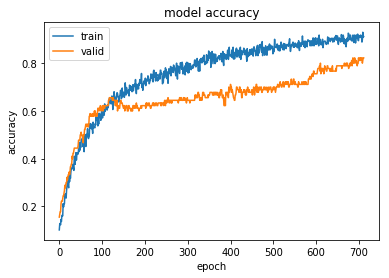

In [11]:
import matplotlib.pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','valid'], loc='upper left')
plt.show()

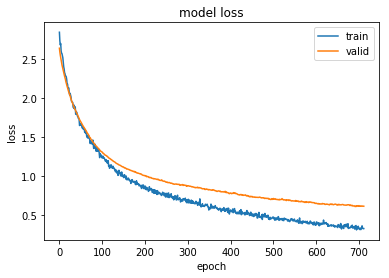

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','valid'], loc='upper right')
plt.show()

Overfitting 了 QQ

In [13]:
loss, acc = model.evaluate(X_test, y_test)
print 'loss: %.2f'%(loss)
print 'acc: %.2f%%'%(acc*100.)

130/130 [==============================] - 0s 506us/step
loss: 0.61
acc: 77.69%


[[13  2  0  0  0  0  0  0  0  0  0  0]
 [ 1  6  3  0  0  0  0  0  0  0  0  0]
 [ 0  0  8  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  8  3  0  0  0  0  0  0  0]
 [ 0  0  0  0  7  4  0  0  0  0  0  0]
 [ 0  0  0  0  2  9  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  5  1  2  0  0  0]
 [ 0  0  0  0  0  0  0  8  2  0  0  0]
 [ 0  0  0  0  0  0  0  2 13  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  3  0  1]
 [ 0  0  0  0  0  0  0  0  0  0 12  1]
 [ 0  0  0  0  0  0  0  0  0  1  3  9]]


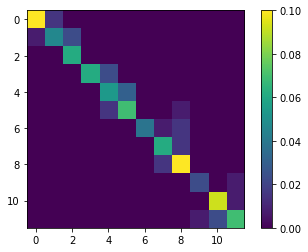

In [14]:
from sklearn.metrics import confusion_matrix, classification_report
pred = model.predict(X_test)
pred = np.argmax(pred, axis=1)
real = np.argmax(y_test, axis=1)
confuse = np.asarray(confusion_matrix(real,pred))
print confuse
print classification_report(real,pred)
confuse = confuse / float(confuse.sum())
plt.imshow(confuse, interpolation='nearest')
plt.colorbar()
plt.show()